# Fine tuning classification example

We will fine-tune an ada classifier to distinguish between TODO

In [1]:
import pandas as pd
import openai
import os
from datasets import load_dataset
import random
import math

random.seed(42)
dataset = load_dataset("amazon_reviews_multi", "all_languages")

Found cached dataset amazon_reviews_multi (/Users/sinanozdemir/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

In [91]:
openai.api_key = os.getenv("OPENAI_API_KEY")


In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 1200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
})

In [13]:
# convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])
english_training_df = training_df[training_df['language'] == 'en']
val_df = pd.DataFrame(dataset['validation'])
english_val_df = val_df[val_df['language'] == 'en']
training_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy


In [14]:
training_df[['review_title', 'review_body', 'stars']].sample(5)

,review_title,review_body,stars
193576,Selber mischen und sparen,Günstiger als Fertigmischungen. Sehr gutes Rei...,5
508826,"Excelente para portátiles, fatal para tablets",Se sale en seguida en las tablets. En el portá...,3
825253,2週間弱で壊れました,以前使用していた同じタイプのものは5ヶ月で壊れましたが、これは2週間弱ですわ。 使い勝手は良...,1
804240,商品が届くのがすごく遅い,再配達苛したのにいつまでたっても届かないと思って置き配にしたら知らない人の玄関の写真が送られ...,1
858620,キャップ‼️,浅いくて形が柔らかく気に入らない。安いのはダメだなぁ〜。別のメーカーの物を購入予定。,2


# Star prediction (sentiment)

In [15]:
english_training_df['prompt'] = english_training_df['review_title'] + '\n\n' + english_training_df['review_body'] + '\n\n###\n\n'
english_val_df['prompt'] = english_val_df['review_title'] + '\n\n' + english_val_df['review_body'] + '\n\n###\n\n'

english_training_df['completion'] = ' ' + english_training_df['stars'].astype(str)  # for sentiment
english_val_df['completion'] = ' ' + english_val_df['stars'].astype(str)  # for sentiment

# drop duplicates
english_training_df.sample(len(english_training_df)).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json("amazon-english-full-train-sentiment-random.jsonl", orient='records', lines=True)
english_val_df.sample(len(english_val_df)).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json("amazon-english-full-val-sentiment-random.jsonl", orient='records', lines=True)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_79201/2710887141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_training_df['prompt'] = english_training_df['review_title'] + '\n\n' + english_training_df['review_body'] + '\n\n###\n\n'
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_79201/2710887141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_val_df['prompt'] = english_val_df['review_title'] + '\n\n' + english_val_df['review_body'] + '\n\n###\n\n'
/var/folder

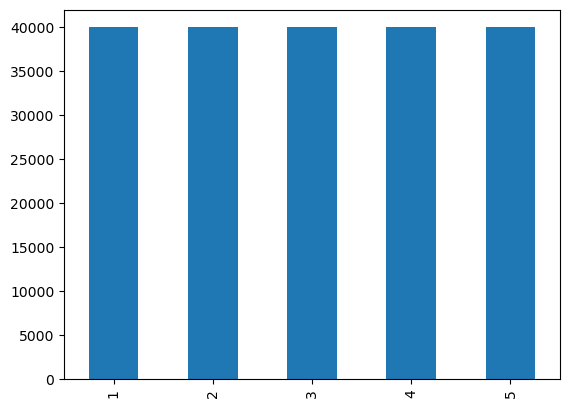

In [16]:
english_training_df['stars'].value_counts().plot(kind='bar')

In [17]:
!openai tools fine_tunes.prepare_data -f amazon-english-full-train-sentiment-random.jsonl

Analyzing...

- Your file contains 199891 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `\n\n###\n\n`

No remediations found.
- [Recommended] Would you like to split into training and validation set? [Y/n]: ^C



In [44]:
!openai api fine_tunes.create -t "amazon-english-full-train-sentiment-random.jsonl" -v "amazon-english-full-val-sentiment-random.jsonl" --compute_classification_metrics --classification_n_classes 5 -m ada --n_epochs 1


Upload progress: 100%|████████████████████| 50.3M/50.3M [00:00<00:00, 36.5Git/s]
Uploaded file from amazon-english-full-train-sentiment-random.jsonl: file-SEDigPmqhtT3QTo20ByIgpus
Upload progress: 100%|█████████████████████| 1.27M/1.27M [00:00<00:00, 316Mit/s]
Uploaded file from amazon-english-full-val-sentiment-random.jsonl: file-u2ik6qOwMXgDyWsTqwzELdPe
Created fine-tune: ft-tnvysbOzvkIfPgtPo6oQ3c7O
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-08 08:51:29] Created fine-tune: ft-tnvysbOzvkIfPgtPo6oQ3c7O
^C


In [51]:
!openai api fine_tunes.follow -i ft-tnvysbOzvkIfPgtPo6oQ3c7O


[2023-05-08 08:51:29] Created fine-tune: ft-tnvysbOzvkIfPgtPo6oQ3c7O
[2023-05-08 08:53:19] Fine-tune costs $4.26
[2023-05-08 08:53:19] Fine-tune enqueued. Queue number: 2
[2023-05-08 08:56:21] Fine-tune is in the queue. Queue number: 1
[2023-05-08 08:57:30] Fine-tune is in the queue. Queue number: 0
[2023-05-08 08:59:17] Fine-tune started
[2023-05-08 09:23:11] Completed epoch 1/1
[2023-05-08 09:25:48] Uploaded model: ada:ft-personal-2023-05-08-16-25-48
[2023-05-08 09:25:49] Uploaded result file: file-QHhhi05wgj0eBQGnpPLxXBaT
[2023-05-08 09:25:49] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-05-08-16-25-48 -p <YOUR_PROMPT>


In [52]:
!openai wandb sync -i ft-tnvysbOzvkIfPgtPo6oQ3c7O


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/oreilly-hands-on-gpt-llm/notebooks/wandb/run-20230508_092918-ft-tnvysbOzvkIfPgtPo6oQ3c7O
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-tnvysbOzvkIfPgtPo6oQ3c7O
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-tnvysbOzvkIfPgtPo6oQ3c7O
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:          classification/accuracy ▁
wandb: classification/weighted_f1_score ▁
wandb:                 elapsed_examples ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                   elapsed_tokens ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                    training_loss

In [ ]:
# ft-tnvysbOzvkIfPgtPo6oQ3c7O ada:ft-personal-2023-05-08-16-25-48

In [53]:
test_df = pd.DataFrame(dataset['test'])
english_test_df = test_df[test_df['language'] == 'en']


In [54]:
english_test_df['completion'] = ' ' + english_test_df['stars'].astype(str)  # for sentiment
english_test_df['prompt'] = english_test_df['review_title'] + '\n\n' + english_test_df['review_body'] + '\n\n###\n\n'


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_79201/453605618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_test_df['completion'] = ' ' + english_test_df['stars'].astype(str)  # for sentiment
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_79201/453605618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_test_df['prompt'] = english_test_df['review_title'] + '\n\n' + english_test_df['review_body'] + '\n\n###\n\n'


In [59]:
def classify(prompt, model, answer=None):
    res = openai.Completion.create(
        model=model, 
        prompt=prompt,
        max_tokens=1, 
        temperature=0, 
        logprobs=5,
    )
    probs = []
    logprobs = res['choices'][0]['logprobs']['top_logprobs']
    for logprob in logprobs:
        _probs = {}
        for key, value in logprob.items():
            _probs[key] = math.exp(value)

        probs.append(_probs)
    pred = res['choices'][0].text.strip()
    if answer:
        correct = str(answer).strip().startswith(pred)
    else:
        correct = None
    return pred, answer, correct, probs

In [60]:
print(english_test_df['prompt'].iloc[0])

Don’t waste your time!

These are AWFUL. They are see through, the fabric feels like tablecloth, and they fit like children’s clothing. Customer service did seem to be nice though, but I regret missing my return date for these. I wouldn’t even donate them because the quality is so poor.

###




In [61]:
classify(english_test_df['prompt'].iloc[0], 'ada:ft-personal-2023-05-08-16-25-48')


('1',
 None,
 None,
 [{' 1': 0.8787214989592752,
   ' 2': 0.11114515825272768,
   ' 3': 0.009247671397136115,
   ' 4': 0.00040601234192277793,
   ' 5': 0.0004006849100512386}])

In [64]:
from tqdm.auto import tqdm
correct = 0
stars_preds = []

for i in tqdm(range(english_test_df.shape[0])):
    _pred, _answer, _correct, _probs = classify(
        english_test_df['prompt'].iloc[i], 
        'ada:ft-personal-2023-05-08-16-25-48', 
        english_test_df['stars'].iloc[i]
    )
    correct += _correct
    stars_preds.append(_pred)

  0%|          | 0/5000 [00:00<?, ?it/s]

# Straight Accuracy (5 classes (1, 2, 3, 4, 5)

In [68]:
import numpy as np
(np.array(stars_preds).astype(int) == english_test_df['stars'].astype(int)).mean()

0.6692

# Re-labeling to have 3 classes ([1, 2], [3], [4, 5])

In [88]:
def relabel(x):
    x = int(x)
    if x < 3:
        return 0
    elif x == 3:
        return 1
    else:
        return 2
    
# "predicting if stars < 3, 3, or >3" three class classification accuracy
(pd.Series(stars_preds).map(relabel).to_numpy() == english_test_df['stars'].map(relabel).to_numpy()).mean()

0.8264

# Re-labeling to have 2 classes ([1, 2, 3], [4, 5])

In [89]:
# "predicting if stars < 4 vs >= 4" binary classification accuracy
((np.array(stars_preds).astype(int) <= 4) == (english_test_df['stars'].astype(int) <= 4)).mean()

0.9168

# Allowing up to 1 degree of error ("1-off")

In [70]:
# Accuracy (off-by-1 so predicting 4 when the answer was 3 or 5 is still correct)
((np.array(stars_preds).astype(int) - english_test_df['stars'].astype(int)).abs() <= 1).mean()

0.9632